# Sprawdzanie środowiska

In [1]:
from platform import python_version

print(python_version())

3.7.4


# Przygotowanie odpowiednich danych

In [2]:
# Jeśli zajdzie potrzeba
# from google.colab import drive

# drive.mount('/content/drive')

In [3]:
'''
Dla PoC wykonuje obliczenia dla:
 * '../data/DogsCats'
Folder docelowy:
 * '../data/Photos'
'''

dir_path = '../data/Photos'
A_folder = 'originals'
B_folder = 'photoshops'

# Załadowanie danych

In [4]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import random
import os

# fix random bo tak ( ͡° ͜ʖ ͡°)
odp = 42
numpy.random.seed(odp)

Using TensorFlow backend.


# Stałe

In [5]:
# Wilkości odpowiednie dla ResNetu

IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Przygotowanie Danych

In [6]:
'''
Opis danych:
1 - klasa 1 -> Originals
0 - klasa 2 -> Photoshops
''' 

A_folder_list = os.listdir(dir_path + '/' + A_folder)
B_folder_list = os.listdir(dir_path + '/' + B_folder)

filenames = []
categories = []

for filename in A_folder_list:
    categories.append(1)
    filenames.append(dir_path + '/' + A_folder + '/' + filename)

for filename in B_folder_list:
    categories.append(0)
    filenames.append(dir_path + '/' + B_folder + '/' + filename)


df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [7]:
# Mieszamy!
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
df.head()

,filename,category
0,../data/Photos/photoshops/co20t8o_0.png,0
1,../data/Photos/photoshops/cb7k2h8_0.jpg,0
2,../data/Photos/photoshops/d23zitu_0.png,0
3,../data/Photos/photoshops/cxevpq7_0.png,0
4,../data/Photos/photoshops/c7st1q3_0.jpg,0


In [9]:
df.shape

(21896, 2)

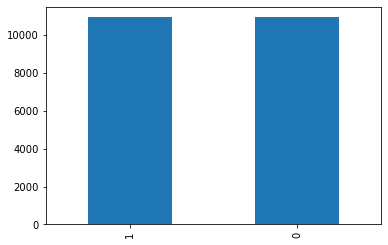

In [10]:
df['category'].value_counts().plot.bar()

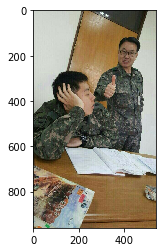

In [11]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)

# Obróbka danych

In [12]:
 '''
Podział danych z całego df na X i y:

X - wszystko oprócz category
y - category
'''

X, y = df.iloc[:, 0:-1], df.iloc[:, -1]

In [13]:
df.head()

,filename,category
0,../data/Photos/photoshops/co20t8o_0.png,0
1,../data/Photos/photoshops/cb7k2h8_0.jpg,0
2,../data/Photos/photoshops/d23zitu_0.png,0
3,../data/Photos/photoshops/cxevpq7_0.png,0
4,../data/Photos/photoshops/c7st1q3_0.jpg,0


In [14]:
X.head()

,filename
0,../data/Photos/photoshops/co20t8o_0.png
1,../data/Photos/photoshops/cb7k2h8_0.jpg
2,../data/Photos/photoshops/d23zitu_0.png
3,../data/Photos/photoshops/cxevpq7_0.png
4,../data/Photos/photoshops/c7st1q3_0.jpg


##### y.head()

In [16]:
# 20% danych do testów
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = odp)
result = next(kf.split(X, y))

'''
Podział danych z całego df na podstawie splitu

train - 80% danych
test  - 20% danych
'''
train = df.iloc[result[0]]
test =  df.iloc[result[1]]

# Reset indeksów
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

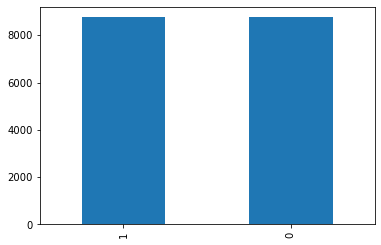

In [17]:
train['category'].value_counts().plot.bar()

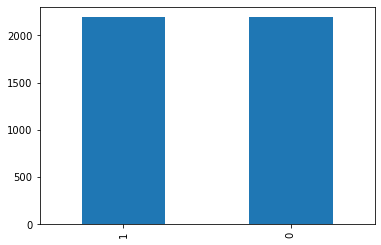

In [18]:
test['category'].value_counts().plot.bar()

In [19]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t train: {train.shape}')
print(f'\t test: {test.shape}')

Kształt danych:
	 df: (21896, 2)
	 train: (17516, 2)
	 test: (4380, 2)


In [20]:
# Upewnienie się że dane w train[filename] i test[filename] są stringiem - lepsze dla generatorów

train['filename'] = train['filename'].astype(str) 
test['filename'] = test['filename'].astype(str)

# Upewnienie się że dane w train[category] i test[category] są stringiem - lepsze dla generatorów

train['category'] = train['category'].astype(str) 
test['category'] = test['category'].astype(str)

In [21]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t train: {train.shape}')
print(f'\t test: {test.shape}')

Kształt danych:
	 df: (21896, 2)
	 train: (17516, 2)
	 test: (4380, 2)


# Funkcję liczące statystyki

In [22]:
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score

In [23]:
def countStats(_y_true, _y_pred):
    accuracy = accuracy_score(_y_true, _y_pred, normalize=True)
    precision = precision_score(_y_true, _y_pred, average='weighted')
    recall = recall_score(_y_true, _y_pred, average='weighted')
    fscore = f1_score(_y_true, _y_pred, average='weighted')
    
    return accuracy, precision, recall, fscore

In [24]:
'''
Źrodło:
https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
'''

def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return f1_val

In [25]:
from mlxtend.plotting import plot_confusion_matrix

def plot_cm(cm, classes):
    plot_confusion_matrix(conf_mat=cm,
                          colorbar=True, 
                          show_absolute=True,
                          show_normed=True,
                          class_names=classes)

In [26]:
'''
cb_early_stopper - skończenie uczenia kiedy val_loss nie będzie się poprawiać przez 10 epok
cb_checkpointer - zapis modelu do pliku 'best.h5' modeli o najlepszym(najmniejszym) val_loss
cb_learning_rate_reduction - zmniejszenie LR jeśli val_loss nie będzie się poprawiać przez 5 epok
'''

EARLY_STOP_PATIENCE = 10
LEARNING_RATE_PATIENCE = 5

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE, verbose=1)
cb_checkpointer = ModelCheckpoint(filepath = 'best.h5', monitor = 'val_loss', save_best_only = True, verbose=1)
cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=LEARNING_RATE_PATIENCE, verbose=1)

# Dobór parametrów

In [27]:
# To Do

batch_size = 50
activation = 'relu'
loss_type = 'categorical_crossentropy'
optimizer = 'Adam'
dropout = 0.25
epochs = 50

# Model

In [28]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, :Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation=activation, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout))

model.add(Conv2D(64, (3, 3), activation=activation))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout))

model.add(Conv2D(128, (3, 3), activation=activation))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout))

model.add(Flatten())
model.add(Dense(512, activation=activation))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)       

# Generatory

In [29]:
'''
Generator dla danych trenningowych
 * losowa rotacja o 15 stopni
 * reskalowanie
 * przybliżenie
 * obrót horyzontalny
 * zakresy dla przesunieć wertykalnych i horyzontalnych
'''

train_datagen = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1./255,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train,
    x_col = 'filename',
    y_col = 'category',
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 17516 validated image filenames belonging to 2 classes.


In [30]:
'''
Generator dla danych testowych
 * reskalowanie
'''

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe( 
    dataframe = test,
    x_col = 'filename',
    y_col = 'category',
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 4380 validated image filenames belonging to 2 classes.


In [31]:
example_df = train.sample(n=1).reset_index(drop=True)

example_generator = train_datagen.flow_from_dataframe(
    dataframe = example_df,
    x_col = 'filename',
    y_col = 'category',
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 1 validated image filenames belonging to 1 classes.


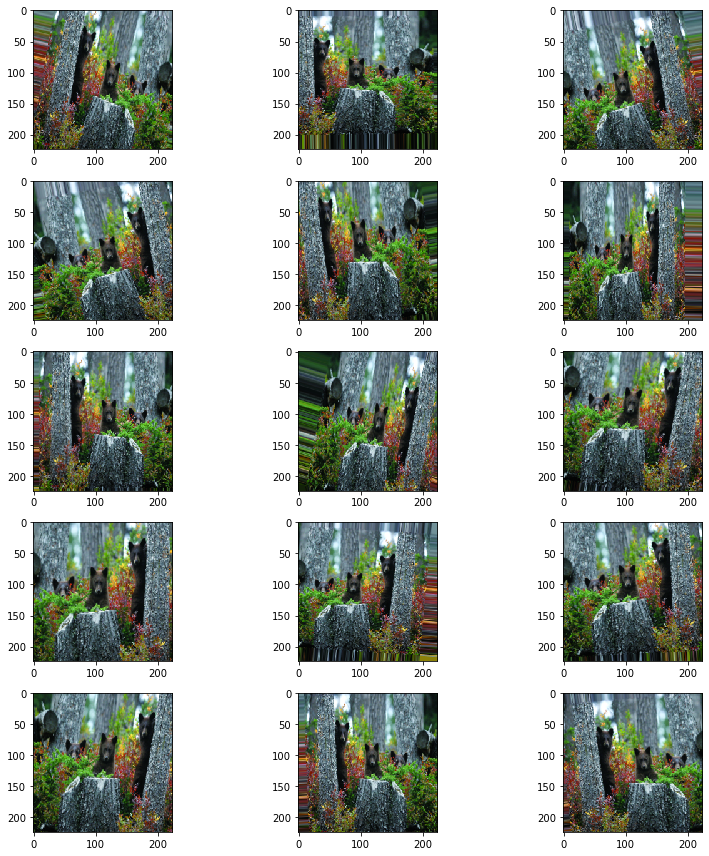

In [32]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit

In [33]:
model.compile(loss=loss_type, optimizer=optimizer, metrics=['accuracy', get_f1])

history = model.fit_generator(
    train_generator, 
    epochs = epochs,
    validation_data = test_generator,
    validation_steps= test.shape[0]//batch_size,
    steps_per_epoch = train.shape[0]//batch_size,
    callbacks = [cb_checkpointer, cb_early_stopper, cb_learning_rate_reduction]
)

# Wczytanie najlepszego
model.load_weights('best.h5')

# Zapis
model.save('the_best_P.h5')

Epoch 1/50
199/350 [================>.............] - ETA: 3:47 - loss: 0.9066 - accuracy: 0.5273 - get_f1: 0.5273

d:\programs\python37\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


350/350 [==============================] - 603s 2s/step - loss: 0.8418 - accuracy: 0.5315 - get_f1: 0.5316 - val_loss: 0.5796 - val_accuracy: 0.5037 - val_get_f1: 0.5037

Epoch 00001: val_loss improved from inf to 0.57963, saving model to best.h5
Epoch 2/50
350/350 [==============================] - 431s 1s/step - loss: 0.7209 - accuracy: 0.5476 - get_f1: 0.5475 - val_loss: 0.6950 - val_accuracy: 0.5748 - val_get_f1: 0.5748

Epoch 00002: val_loss did not improve from 0.57963
Epoch 3/50
350/350 [==============================] - 427s 1s/step - loss: 0.6957 - accuracy: 0.5692 - get_f1: 0.5694 - val_loss: 0.7169 - val_accuracy: 0.5326 - val_get_f1: 0.5324

Epoch 00003: val_loss did not improve from 0.57963
Epoch 4/50
350/350 [==============================] - 425s 1s/step - loss: 0.6868 - accuracy: 0.5674 - get_f1: 0.5676 - val_loss: 0.5777 - val_accuracy: 0.5794 - val_get_f1: 0.5791

Epoch 00004: val_loss improved from 0.57963 to 0.57772, saving model to best.h5
Epoch 5/50
350/350 [=====

# Statystyki

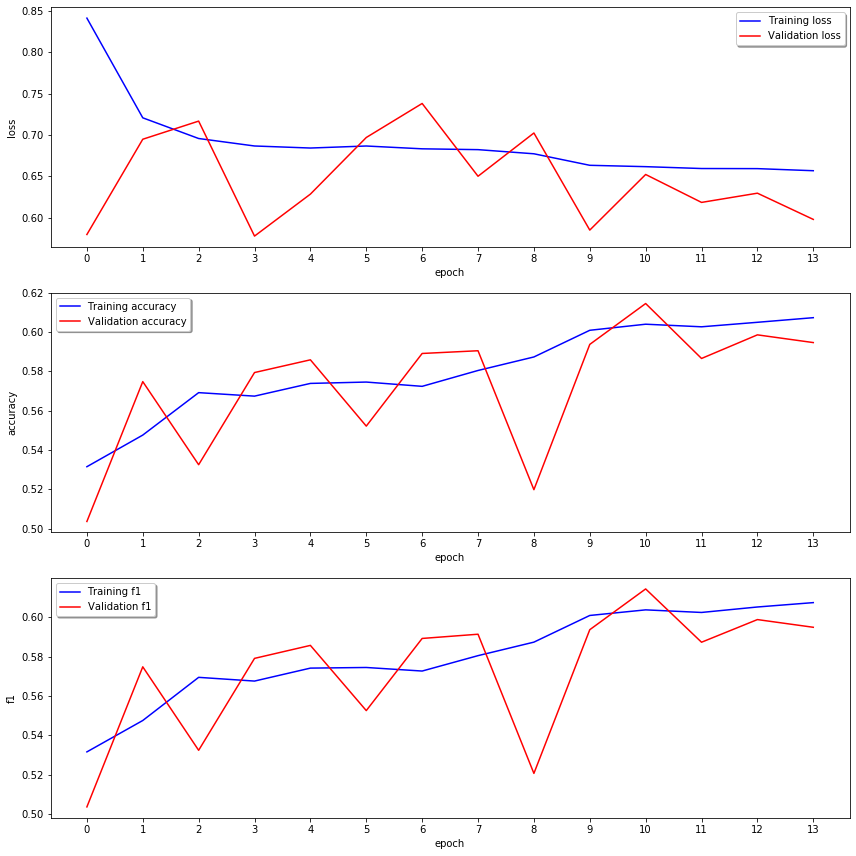

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

# Wykres loss
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(numpy.arange(0, len(history.history['val_loss']), 1))
ax1.legend(loc='best', shadow=True)
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')

# Wykres accuracy
ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(numpy.arange(0, len(history.history['val_accuracy']), 1))
ax2.legend(loc='best', shadow=True)
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')

# Wykres F1
ax3.plot(history.history['get_f1'], color='b', label="Training f1")
ax3.plot(history.history['val_get_f1'], color='r',label="Validation f1")
ax3.set_xticks(numpy.arange(0, len(history.history['get_f1']), 1))
ax3.legend(loc='best', shadow=True)
ax3.set_ylabel('f1')
ax3.set_xlabel('epoch')


plt.tight_layout()
plt.show()

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def countStats(_y_true, _y_pred):
    accuracy = accuracy_score(_y_true, _y_pred, normalize=True)
    precision = precision_score(_y_true, _y_pred, average='weighted')
    recall = recall_score(_y_true, _y_pred, average='weighted')
    fscore = f1_score(_y_true, _y_pred, average='weighted')
    
    return accuracy, precision, recall, fscore

In [36]:
stats_df = pd.DataFrame({
    'filename': test['filename'],
    'category': test['category'],
    'predict': None
})

# Mieszamy!
stats_df = stats_df.sample(frac=1).reset_index(drop=True)

stats_df.head()

,filename,category,predict
0,../data/Photos/photoshops/coto0g5_0.jpg,0,None
1,../data/Photos/originals/2ph59l.jpg,1,None
2,../data/Photos/photoshops/c7lzclr_0.png,0,None
3,../data/Photos/photoshops/c7pbqpn_0.jpg,0,None
4,../data/Photos/photoshops/dkvwnzj_0.jpg,0,None


In [37]:
validate_datagen = ImageDataGenerator(rescale=1./255)

validate_generator = validate_datagen.flow_from_dataframe( 
    dataframe = stats_df,
    x_col = 'filename',
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 4380 validated image filenames.


In [38]:
predict = model.predict_generator(validate_generator, verbose=True)

88/88 [==============================] - 54s 618ms/step


In [39]:
# Zamiana z one hot encodera na jedno wyjście
stats_df['predict'] = numpy.argmax(predict, axis=-1)

In [40]:
stats_df.head()

,filename,category,predict
0,../data/Photos/photoshops/coto0g5_0.jpg,0,1
1,../data/Photos/originals/2ph59l.jpg,1,0
2,../data/Photos/photoshops/c7lzclr_0.png,0,1
3,../data/Photos/photoshops/c7pbqpn_0.jpg,0,1
4,../data/Photos/photoshops/dkvwnzj_0.jpg,0,1


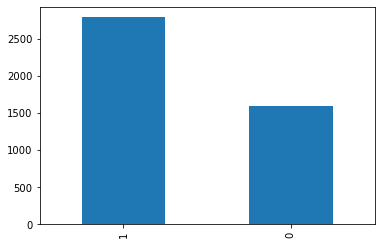

In [41]:
stats_df['predict'].value_counts().plot.bar()

In [42]:
y_true = stats_df['category'].to_numpy().astype(int)
y_pred = stats_df['predict'].to_numpy().astype(int)

In [43]:
 cm = confusion_matrix(y_true, y_pred)

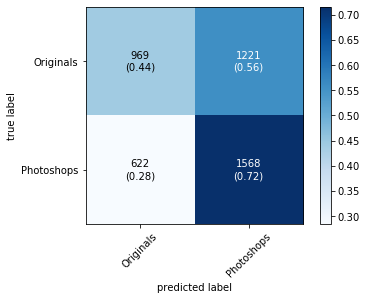

In [44]:
plot_cm(cm, ['Originals', 'Photoshops'])

In [45]:
print(cm)

[[ 969 1221]
 [ 622 1568]]


In [46]:
accuracy, precision, recall, fscore = countStats(y_true, y_pred)
print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-score: {fscore}')

Accuracy: 0.5792237442922374
Precision: 0.5856297941608173
Recall: 0.5792237442922374
F-score: 0.571204082271167


In [47]:
loss, accuracy, get_f1  = model.evaluate_generator(test_generator, verbose=True)

88/88 [==============================] - 57s 642ms/step


In [48]:
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')
print(f'Test F1: {get_f1:.3}')

Test loss: 0.671
Test accuracy: 0.579
Test F1: 0.579
